In [ ]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
logging.basicConfig(level=logging.INFO)

## Investment Assignment

## Introduction<br>
This is the Assignment for the Investment case study for Spark Funds. **Spark Funds**, an asset management company. Spark Funds wants to make investments in a few companies. The CEO of Spark Funds wants to understand the **global trends in investments** so that she can take the investment decisions effectively.<br>
<br>
## Business Understanding and Domain (CRISP-DM Step #1)<br>
- Spark Funds wants to invest **between 5 to 15 million USD** per round of investment<br>
- Spark Funds wants to invest **only in English-speaking countries** because of the ease of communication with the companies it would invest in<br>
- Spark Funds wants to invest where most other investors are investing. This pattern is often observed among early stage startup investors.

## Objective<br>
The objective is to identify the **best sectors, countries, and a suitable investment type** for making investments. The overall strategy is to invest where others are investing, implying that the 'best' sectors and countries are the ones 'where most investors are investing'.

## Data Sources<br>
- Company Profiles (Crunchbase)<br>
- Investment Rounds Data (Crunchbase)<br>
- Category Mapping

In [ ]:
ENGLISH_COUNTRIES = ['AUS', 'NZL', 'GBR', 'USA', 'ATG', 'BHS', 'BRB', 'BLZ', 'BWA', 'BDI', 'CMR', 'CAN', 'DMA', 'SWZ',
                     'FJI', 'GMB', 'GHA', 'GRD', 'GUY', 'IND', 'IRL', 'JAM', 'KEN', 'KIR', 'LSO', 'LBR', 'MWI', 'MLT',
                     'MHL', 'MUS', 'FSM', 'NAM', 'NRU', 'NGA', 'PAK', 'PLW', 'PNG', 'PHL', 'KNA', 'LCA', 'VCT', 'WSM',
                     'SYC', 'SLE', 'SGP', 'SLB', 'ZAF', 'SSD', 'SDN', 'TZA', 'TON', 'TTO', 'TUV', 'VUT', 'ZMB', 'ZWE',
                     'BHR', 'BGD', 'BRN', 'KHM', 'CYP', 'ERI', 'ETH', 'ISR', 'JOR', 'KWT', 'MYS', 'MDV', 'MMR', 'OMN',
                     'QAT', 'RWA', 'LKA', 'UGA', 'ARE']

The above English-speaking countries have been taken from Wikipedia using a script which uses BeautifulSoup to scrape the HTML tables, and output the result as a list.

In [ ]:
ORGANIZATION = "/organization/"
EMPTY_STRING = ""
FIVE_MILLION = 5000000
FIFTEEN_MILLION = 15000000

A bunch of constants are set up so that strings don't clutter the source everywhere.

In [ ]:
class MainSectors:
    OTHERS = "Others"
    HEALTH = "Health"
    MANUFACTURING = "Manufacturing"
    SOCIAL_FINANCE_ANALYTICS_ADVERTISING = "Social, Finance, Analytics, Advertising"
    ENTERTAINMENT = "Entertainment"
    NEWS_SEARCH_MESSAGING = "News, Search and Messaging"
    CLEANTECH_SEMICONDUCTORS = "Cleantech / Semiconductors"

In [ ]:
class Columns:
    TOTAL_INVESTMENT_AMOUNT = "total_investment_amount"
    NUMBER_OF_INVESTMENTS = "number_of_investments"
    ROUNDS2_COMPANY_PERMALINK = "company_permalink"
    COMPANIES_COMPANY_PERMALINK = "permalink"
    ROUNDS2_COMPANY_PERMALINK_LOWERCASE = "company_permalink_lowercase"
    COMPANIES_COMPANY_PERMALINK_LOWERCASE = "permalink_lowercase"
    COMPANIES_NAME = "name"
    ORGANIZATION = "/organization/"
    FUNDING_ROUND_TYPE = "funding_round_type"
    RAISED_AMOUNT_USD = "raised_amount_usd"
    COUNTRY_CODE = "country_code"
    CATEGORY_LIST = "category_list"
    VALUE = "value"
    VARIABLE = "variable"
    PRIMARY_SECTOR = "primary_sector"
    MAIN_SECTOR = "main_sector"

In [ ]:
class InvestmentTypes:
    SEED = "seed"
    ANGEL = "angel"
    VENTURE = "venture"
    PRIVATE_EQUITY = "private_equity"

This is used to generate permalinks from company names

In [ ]:
def sanitized(s):
    return s.replace(" ", "-").replace(".", "-")

In [ ]:
def with_organization_prefix(s):
    return f"{ORGANIZATION}{s}"

This is used to generate a pattern which is used to locate a permalink within the rounds frame

In [ ]:
def pattern_for_rounds_matching(company_name):
    return f'{ORGANIZATION}{sanitized(company_name.lower())}'

In [ ]:
def constant(x):
    return lambda company_name: x

In [ ]:
def merge_companies_rounds(companies, rounds):
    logging.info(f"Number of Companies: {len(companies)}")
    logging.info(f"Number of Rounds: {len(rounds)}")
    return pd.merge(companies, rounds, left_on=Columns.COMPANIES_COMPANY_PERMALINK_LOWERCASE,
                    right_on=Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE)

In [ ]:
def boxplot(investment_type, x, y, axis, funding_by_investment_type):
    logging.info(f"Statistics for {investment_type} investments:")
    logging.info(funding_by_investment_type.loc[investment_type, Columns.RAISED_AMOUNT_USD].describe().apply(
        lambda x: format(x, 'f')))
    # logging.info(f"Number of {investment_type} investments: {len(stuff.loc[investment_type, Columns.RAISED_AMOUNT_USD])}" )
    # logging.info(f"Median investment oof type {investment_type}: {stuff.loc[investment_type, Columns.RAISED_AMOUNT_USD].median()}" )
    axis[x, y].boxplot(funding_by_investment_type.loc[investment_type, Columns.RAISED_AMOUNT_USD])
    axis[x, y].set_title(investment_type)

In [ ]:
def analyse_investment_types(master_funding):
    # Use only 4 investment types
    investments_with_4_types = master_funding[(master_funding[Columns.FUNDING_ROUND_TYPE] == InvestmentTypes.ANGEL) |
                                              (master_funding[Columns.FUNDING_ROUND_TYPE] == InvestmentTypes.SEED) |
                                              (master_funding[Columns.FUNDING_ROUND_TYPE] == InvestmentTypes.VENTURE) |
                                              (master_funding[
                                                   Columns.FUNDING_ROUND_TYPE] == InvestmentTypes.PRIVATE_EQUITY)]
    logging.info(f"Only English Investments of 4 Types: {len(investments_with_4_types)}")
    funding_amounts_with_investment_types = investments_with_4_types[
        [Columns.FUNDING_ROUND_TYPE, Columns.RAISED_AMOUNT_USD]]

    # Remove outliers
    funding_by_investment_type = funding_amounts_with_investment_types.groupby(Columns.FUNDING_ROUND_TYPE)
    funding_by_investment_type_without_outliers = funding_by_investment_type.apply(lambda g: g[
        (g[Columns.RAISED_AMOUNT_USD] > g[Columns.RAISED_AMOUNT_USD].quantile(q=0.05)) & (
                g[Columns.RAISED_AMOUNT_USD] < g[Columns.RAISED_AMOUNT_USD].quantile(q=0.90))])

    # Create boxplots
    figure, axis = plt.subplots(2, 2)
    boxplot(InvestmentTypes.SEED, 0, 0, axis, funding_by_investment_type_without_outliers)
    boxplot(InvestmentTypes.ANGEL, 0, 1, axis, funding_by_investment_type_without_outliers)
    boxplot(InvestmentTypes.VENTURE, 1, 0, axis, funding_by_investment_type_without_outliers)
    boxplot(InvestmentTypes.PRIVATE_EQUITY, 1, 1, axis, funding_by_investment_type_without_outliers)
    return investments_with_4_types

In [ ]:
def english_speaking_countries(fundings):
    only_english_company_investments = fundings[fundings[Columns.COUNTRY_CODE].isin(ENGLISH_COUNTRIES)]
    logging.info(f"English Company Investments: {len(only_english_company_investments)}")
    logging.info(f"Non-English Company Investments: {len(fundings) - len(only_english_company_investments)}")
    return only_english_company_investments

In [ ]:
def top_9_countries(investments):
    aggregator = {}
    aggregator[Columns.RAISED_AMOUNT_USD] = "sum"
    investments_by_country = investments.groupby(Columns.COUNTRY_CODE)
    sorted_countrywise_investments = investments_by_country.agg(aggregator).reset_index(level=0,
                                                                                        inplace=False).sort_values(
        by=Columns.RAISED_AMOUNT_USD, ascending=False)
    logging.info(f"Countrywise Investments:")
    logging.info(sorted_countrywise_investments)
    return sorted_countrywise_investments.head(9)

In [ ]:
def investments_for_country_with_investment_constraints(investments, country_code):
    return investments[(investments[Columns.COUNTRY_CODE] == country_code) &
                       (investments[Columns.RAISED_AMOUNT_USD] >= FIVE_MILLION) &
                       (investments[Columns.RAISED_AMOUNT_USD] <= FIFTEEN_MILLION)]

In [ ]:
def heavily_invested_sectors(investments, top9):
    logging.info(top9)
    country_1 = top9[Columns.COUNTRY_CODE].iloc[0]
    country_2 = top9[Columns.COUNTRY_CODE].iloc[1]
    country_3 = top9[Columns.COUNTRY_CODE].iloc[2]
    logging.info(f"{country_1}-{country_2}-{country_3}")
    D1 = investments_for_country_with_investment_constraints(investments, country_1)
    D2 = investments_for_country_with_investment_constraints(investments, country_2)
    D3 = investments_for_country_with_investment_constraints(investments, country_3)
    logging.info(f"1. {country_1}: {len(D1)}")
    logging.info(f"2. {country_2}: {len(D2)}")
    logging.info(f"3. {country_3}: {len(D3)}")
    data = [aggregate_investment_stats(country_1, D1),
            aggregate_investment_stats(country_2, D2),
            aggregate_investment_stats(country_3, D3)]
    aggregate_investment_stats_by_country = pd.DataFrame(data,
                                                         columns=[Columns.COUNTRY_CODE, Columns.TOTAL_INVESTMENT_AMOUNT,
                                                                  Columns.NUMBER_OF_INVESTMENTS])
    logging.info("AGGREGATE_INVESTMENT_STATS_BY_COUNTRY:")
    logging.info("--------------------------------------")
    logging.info(aggregate_investment_stats_by_country)
    d1_sectorwise_statistics = sectorwise_stats(country_1, D1)
    d2_sectorwise_statistics = sectorwise_stats(country_2, D2)
    d3_sectorwise_statistics = sectorwise_stats(country_3, D3)
    return aggregate_investment_stats_by_country, d1_sectorwise_statistics, d2_sectorwise_statistics, d3_sectorwise_statistics, D1, D2, D3

In [ ]:
def aggregate_investment_stats(country_code, country_investment_table):
    return [country_code, country_investment_table[Columns.RAISED_AMOUNT_USD].sum(), len(country_investment_table)]

In [ ]:
def sectorwise_stats(country_code, investments):
    investments_by_main_sector = investments.groupby(Columns.MAIN_SECTOR)
    sectorwise_investment_statistics = investments_by_main_sector.agg({Columns.RAISED_AMOUNT_USD: ["sum", "count"]})
    sectorwise_investment_statistics.columns = sectorwise_investment_statistics.columns.droplevel(0)
    sectorwise_investment_statistics = sectorwise_investment_statistics.sort_values(by="count", ascending=False)
    logging.info(f"SECTORWISE_INVESTMENT_STATISTICS for {country_code}")
    logging.info("---------------------------------------------")
    logging.info(sectorwise_investment_statistics)
    return sectorwise_investment_statistics.reset_index()

In [ ]:
def fix_case(companies, rounds):
    companies[Columns.COMPANIES_COMPANY_PERMALINK_LOWERCASE] = companies[
        Columns.COMPANIES_COMPANY_PERMALINK].str.lower()
    rounds[Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE] = rounds[Columns.ROUNDS2_COMPANY_PERMALINK].str.lower()

This is the main function which is invoked to run all the analyses and generate all the plots.

In [ ]:
def analyse():
    companies = pd.read_csv("../data/companies.csv")
    rounds = pd.read_csv("../data/rounds2.csv")
    mapping = pd.read_csv("../data/mapping.csv")
    logging.debug(companies.columns)
    logging.debug(mapping.columns)
    logging.debug(rounds.columns)
    sector_map = mapping_dict(mapping)

    # Fix case
    fix_case(companies, rounds)
    unique_companies_in_companies, unique_companies_in_rounds2 = unique_companies(companies, rounds)

    # How many unique companies are present in rounds?
    logging.info(f"Unique companies in rounds2 (Before Cleanup): {len(unique_companies_in_rounds2)}")

    # How many unique companies are present in companies?
    logging.info(f"Unique companies in companies (Before Cleanup): {len(unique_companies_in_companies)}")

    # In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.
    # permalink

    # Are there any companies in the rounds file which are not present in companies? Answer yes or no: Y/N
    companies_not_in_companies = set(unique_companies_in_rounds2).difference(set(unique_companies_in_companies))
    companies_not_in_rounds2 = set(unique_companies_in_companies).difference(set(unique_companies_in_rounds2))
    logging.info(f"Companies in rounds2 but not in companies: {len(companies_not_in_companies)}")
    logging.debug(companies_not_in_companies)
    logging.info(f"Companies in companies but not in rounds2: {len(companies_not_in_rounds2)}")
    # YES
    unique_companies_in_companies_after_cleanup, unique_companies_in_rounds2_after_cleanup = clean_permalinks(companies,
                                                                                                              rounds)
    # How many unique companies are present in rounds?
    logging.info(f"Unique companies in rounds2 (After Cleanup): {len(unique_companies_in_rounds2_after_cleanup)}")

    # How many unique companies are present in companies?
    logging.info(f"Unique companies in companies (After Cleanup): {len(unique_companies_in_companies_after_cleanup)}")
    master_frame = merge_companies_rounds(companies, rounds)
    setup_sectors(master_frame, sector_map)
    logging.info(f"MASTER FUNDING FRAME: {len(master_frame)}")
    logging.info(master_frame.columns)
    logging.debug(master_frame.head(10))
    logging.info("-----------------------------------------")
    english_master_funding = english_speaking_countries(master_frame)
    logging.info(f"Only English Investments: {len(english_master_funding)}")
    investments_english_4_types = analyse_investment_types(english_master_funding)

    # Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity) and report the answers in Table 2.1
    # Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?
    # Venture Investments
    english_venture_investments_with_outliers = investments_english_4_types[
        investments_english_4_types[Columns.FUNDING_ROUND_TYPE] == InvestmentTypes.VENTURE]
    logging.info(f"English-only Venture Investments Selected: {len(english_venture_investments_with_outliers)}")
    top9 = top_9_countries(english_venture_investments_with_outliers)
    logging.info("Top 9 Countrywise Investments:")
    logging.info(top9)
    logging.info("---------------------------------------------")
    # Fill Top 3 Countries from the Above List
    logging.info(english_venture_investments_with_outliers[Columns.MAIN_SECTOR].head(10))
    aggregate_investment_stats_by_country, d1_sectorwise_stats, d2_sectorwise_stats, d3_sectorwise_stats, D1, D2, D3 = heavily_invested_sectors(
        english_venture_investments_with_outliers, top9)
    most_invested_company_in_ranked_sector(0, D1, d1_sectorwise_stats)
    most_invested_company_in_ranked_sector(1, D1, d1_sectorwise_stats)
    logging.info("-------------------------------------------------------------------")
    most_invested_company_in_ranked_sector(0, D2, d2_sectorwise_stats)
    most_invested_company_in_ranked_sector(1, D2, d2_sectorwise_stats)
    logging.info("-------------------------------------------------------------------")
    most_invested_company_in_ranked_sector(0, D3, d3_sectorwise_stats)
    most_invested_company_in_ranked_sector(1, D3, d3_sectorwise_stats)
    logging.info("-------------------------------------------------------------------")
    plot_top_9_countries_by_investment_amount(top9)
    plot_top_3_sectors_by_count_by_country(d1_sectorwise_stats, d2_sectorwise_stats, d3_sectorwise_stats, D1, D2, D3)
    plt.subplots_adjust(hspace=1.5)
    plt.show()

In [ ]:
def plot_top_3_sectors_by_count_by_country(d1_sectorwise_stats, d2_sectorwise_stats, d3_sectorwise_stats, D1, D2, D3):
    f3, a3 = plt.subplots(1, 3)
    plot_top_3_sectors_by_count_for_country(a3[0], d1_sectorwise_stats, D1)
    plot_top_3_sectors_by_count_for_country(a3[1], d2_sectorwise_stats, D2)
    plot_top_3_sectors_by_count_for_country(a3[2], d3_sectorwise_stats, D3)

In [ ]:
def plot_top_9_countries_by_investment_amount(top9):
    f2, a2 = plt.subplots(1, 1)
    a2.tick_params(labelrotation=90)
    a2.set_title("Top 9 Countries by Investment Amount (Log Count)")
    log_count = np.log10(top9[Columns.RAISED_AMOUNT_USD])
    a2.bar(top9[Columns.COUNTRY_CODE], log_count)

In [ ]:
def plot_top_3_sectors_by_count_for_country(axes, d1_sectorwise_stats, investments_for_country):
    axes.tick_params(labelrotation=90)
    axes.set_title(f"Investment for {investments_for_country.iloc[0][Columns.COUNTRY_CODE]}")
    axes.bar(d1_sectorwise_stats[Columns.MAIN_SECTOR][:3], (d1_sectorwise_stats["count"][:3]))

In [ ]:
def most_invested_company_in_ranked_sector(sector_rank, investments_for_country, country_sectorwise_stats):
    ranked_sector_in_country = country_sectorwise_stats[Columns.MAIN_SECTOR].iloc[sector_rank]
    sorted_investments_in_top_sector_for_country = investments_for_country[
        investments_for_country[Columns.MAIN_SECTOR] == ranked_sector_in_country].sort_values(
        by=Columns.RAISED_AMOUNT_USD)
    country_code = sorted_investments_in_top_sector_for_country[Columns.COUNTRY_CODE].iloc[0]
    most_invested_company = sorted_investments_in_top_sector_for_country[Columns.COMPANIES_NAME].iloc[0]
    investment_in_most_invested_company = sorted_investments_in_top_sector_for_country[Columns.RAISED_AMOUNT_USD].iloc[
        0]
    logging.info(
        f"MOST INVESTED COMPANY IN {country_code} for sector {ranked_sector_in_country}, ranked #{sector_rank + 1}: {most_invested_company}")
    return [country_code, ranked_sector_in_country, sector_rank, most_invested_company,
            investment_in_most_invested_company]

In [ ]:
def setup_sectors(master_funding, sector_map):
    master_funding[Columns.PRIMARY_SECTOR] = master_funding[Columns.CATEGORY_LIST].str.split("|").apply(
        lambda splits: splits[0] if isinstance(splits, list) else EMPTY_STRING)
    master_funding[Columns.MAIN_SECTOR] = master_funding[Columns.PRIMARY_SECTOR].apply(
        lambda primary_sector: sector_map[primary_sector])

This is part of the data cleaning exercise for mappings. Primary sectors are usually connected to a main sector, but there are several primary sectors do not have this mapping.<br>
This function adds those missing mappings.

In [ ]:
def mapping_dict(mapping):
    mapping = mapping.melt([Columns.CATEGORY_LIST])

    # Cleaning data
    mapping[Columns.CATEGORY_LIST] = mapping[Columns.CATEGORY_LIST].str.replace("0", "na")
    mapping.loc[mapping[Columns.CATEGORY_LIST] == "nanotechnology", Columns.CATEGORY_LIST] = "Nanotechnology"
    mapping.loc[mapping[
                    Columns.CATEGORY_LIST] == "natural Language Processing", Columns.CATEGORY_LIST] = "Natural Language Processing"
    mapping.loc[mapping[Columns.CATEGORY_LIST] == "natural Resources", Columns.CATEGORY_LIST] = "Natural Resources"
    mapping.loc[mapping[Columns.CATEGORY_LIST] == "navigation", Columns.CATEGORY_LIST] = "Navigation"
    mapping = mapping[mapping[Columns.VALUE] == 1][[Columns.CATEGORY_LIST, Columns.VARIABLE]]
    mappings_as_list = mapping.values.tolist()
    mapping_as_dict = {}
    for pair in mappings_as_list:
        mapping_as_dict[pair[0] if isinstance(pair[0], str) else EMPTY_STRING] = pair[1]
    mapping_as_dict["Self Development"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Cause Marketing"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Real Estate Investors"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["English-Speaking"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Navigation"] = MainSectors.OTHERS
    mapping_as_dict["Deep Information Technology"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Toys"] = MainSectors.ENTERTAINMENT
    mapping_as_dict["Generation Y-Z"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Spas"] = MainSectors.HEALTH
    mapping_as_dict["Enterprise Hardware"] = MainSectors.OTHERS
    mapping_as_dict["Social Media Advertising"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Darknet"] = MainSectors.OTHERS
    mapping_as_dict["Natural Gas Uses"] = MainSectors.OTHERS
    mapping_as_dict["Natural Language Processing"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Internet Technology"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Nightlife"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Adaptive Equipment"] = MainSectors.OTHERS
    mapping_as_dict["Enterprise 2.0"] = MainSectors.NEWS_SEARCH_MESSAGING
    mapping_as_dict["Natural Resources"] = MainSectors.OTHERS
    mapping_as_dict["Tutoring"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Internet TV"] = MainSectors.ENTERTAINMENT
    mapping_as_dict["Skill Gaming"] = MainSectors.ENTERTAINMENT
    mapping_as_dict["Racing"] = MainSectors.ENTERTAINMENT
    mapping_as_dict["Specialty Retail"] = MainSectors.OTHERS
    mapping_as_dict["Swimming"] = MainSectors.HEALTH
    mapping_as_dict["Registrars"] = MainSectors.OTHERS
    mapping_as_dict["Golf Equipment"] = MainSectors.ENTERTAINMENT
    mapping_as_dict["Biotechnology and Semiconductor"] = MainSectors.CLEANTECH_SEMICONDUCTORS
    mapping_as_dict["Vacation Rentals"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Google Glass"] = MainSectors.NEWS_SEARCH_MESSAGING
    mapping_as_dict["Rapidly Expanding"] = MainSectors.OTHERS
    mapping_as_dict["Infrastructure Builders"] = MainSectors.MANUFACTURING
    mapping_as_dict["Group Email"] = MainSectors.NEWS_SEARCH_MESSAGING
    mapping_as_dict["Kinect"] = MainSectors.ENTERTAINMENT
    mapping_as_dict["Product Search"] = MainSectors.NEWS_SEARCH_MESSAGING
    mapping_as_dict["Sex Industry"] = MainSectors.ENTERTAINMENT
    mapping_as_dict["Psychology"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Testing"] = MainSectors.OTHERS
    mapping_as_dict["GreenTech"] = MainSectors.CLEANTECH_SEMICONDUCTORS
    mapping_as_dict["Subscription Businesses"] = MainSectors.NEWS_SEARCH_MESSAGING
    mapping_as_dict["Retirement"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Lingerie"] = MainSectors.OTHERS
    mapping_as_dict["Experience Design"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    mapping_as_dict["Mobile Emergency&Health"] = MainSectors.HEALTH
    mapping_as_dict["Sponsorship"] = MainSectors.SOCIAL_FINANCE_ANALYTICS_ADVERTISING
    logging.debug("Mapping is:")
    logging.debug(mapping_as_dict)
    return mapping_as_dict

This is part of the data cleaning exercise for companies and rounds.<br>
Permalinks are sometimes corrupted because of mistranslation of special characters<br>
This function fixes those permalinks.

In [ ]:
def clean_permalinks(companies, rounds):
    # ### Pattern 1
    # This is the most common type of malformed data. In this the permalink in the *companies* dataset is malformed, mostly because it uses Mandarin characters. The corresponding company name is well-formed. The corresponding permalink in the *rounds2* data set is also well-formed.
    fix_permalink_from_rounds = fix_permalink_from_rounds_builder(pattern_for_rounds_matching, companies, rounds)
    fix_permalink_from_rounds("Boréal Bikes Incorporated")
    fix_permalink_from_rounds("Tío Conejo")
    fix_permalink_from_rounds("Monnier Frères")
    fix_permalink_from_rounds("Affluent Attaché Club",
                              locator=constant(with_organization_prefix("affluent-attaché-club-2")))
    fix_permalink_from_rounds("Jean Pütz Produkte")
    fix_permalink_from_rounds("PatroFİN")
    fix_permalink_from_rounds("Salão VIP")
    fix_permalink_from_rounds("Proděti.cz")
    fix_permalink_from_rounds("LawPadi", locator=constant(with_organization_prefix("lawpàdí")))
    fix_permalink_from_rounds("eTool.io")
    fix_permalink_from_rounds("Crème & Ciseaux", locator=constant(with_organization_prefix("crème-ciseaux")))
    fix_permalink_from_rounds("Prześwietl.pl")
    fix_permalink_from_rounds("Capptú")
    fix_permalink_from_rounds("Gráfica en línea")
    fix_permalink_from_rounds("IGNIA Bienes Raíces")
    fix_permalink_from_rounds("Bricoprivé.com")
    fix_permalink_from_rounds("Médica Santa Carmen",
                              locator=constant(with_organization_prefix("médica-santa-carmen-2")))
    fix_permalink_from_rounds("E CÚBICA", locator=constant(with_organization_prefix("e-cêbica")))
    fix_permalink_from_rounds("Vá de Táxi")

    # ### Pattern 3
    # The third common pattern of malformed data is where the *companies* dataset has the correctly generated permalink, but the corresponding permalink in the *rounds2* dataset is malformed.
    fix_permalink_from_companies("It’s All About Me", "S-ALL-ABOUT-ME", companies, rounds)
    fix_permalink_from_companies("Whodat’s Spaces", "WHODAT", companies, rounds)
    fix_permalink_from_companies("know’N’act", "KNOW", companies, rounds)
    fix_permalink_from_companies("iProof - The Foundation for the Internet of Things™",
                                 "IPROOF---THE-FOUNDATION-FOR-THE-INTERNET-OF-THINGS", companies, rounds)
    fix_permalink_from_companies("ÁERON", "�eron", companies, rounds)
    # This needs some extra fixing
    fix_permalink_from_companies("Crème & Ciseaux", "e-ciseaux", companies, rounds)

    # ### Pattern 2
    # This is the second most common type of malformed data. In this case, the permalinks for a company are malformed in different ways in both the *companies* and *rounds2* dataset, and thus do not match. This occurs because of Mandarin characters in the company name not translating correcting to the permalinks. The solution is to regenerate the permalink from the (well-formed) company name and use that in both the *companies* and *rounds2* dataset.
    regenerate_permalink("ZenGame", "ZenGame 禅游科技", companies, rounds)
    regenerate_permalink("EnergyStone Games", "EnergyStone Games 灵石游戏", companies, rounds)
    regenerate_permalink("Magnet Tech ", "Magnet Tech 磁石科技", companies, rounds)
    regenerate_permalink("Huizuche.com", "Huizuche.com 惠租车", companies, rounds)
    regenerate_permalink("Inveno ", "Inveno 英威诺", companies, rounds)
    regenerate_permalink("Weiche Tech ", "Weiche Tech 喂车科技", companies, rounds)
    regenerate_permalink("TipCat Interactive", "TipCat Interactive 沙舟信息科技", companies, rounds)
    regenerate_permalink("Jiwu", "Jiwu 吉屋网", companies, rounds)
    regenerate_permalink("TalentSigned", "TalentSigned™", companies, rounds)
    regenerate_permalink("Asiansbook", "Asiansbook™", companies, rounds)
    regenerate_permalink("Reklam-Ve-Tan", "İnovatiff Reklam ve Tanıtım Hizmetleri Tic", companies, rounds, EMPTY_STRING)
    regenerate_permalink("thế-giới-di", "The Gioi Di Dong", companies,
                         rounds)  # This permalink is mangled in both data sets, generated new permalink
    regenerate_permalink("k��k", "KÖÖK", companies, rounds)
    unique_companies_in_companies, unique_companies_in_rounds = unique_companies(companies, rounds)
    logging.debug(set(unique_companies_in_rounds).difference(set(unique_companies_in_companies)))
    logging.debug(set(unique_companies_in_companies).difference(set(unique_companies_in_rounds)))
    return unique_companies_in_companies, unique_companies_in_rounds

This regenerates permalinks from a company name<br>
For **Pattern 2**, the permalinks were regenerated by sanitising the (well-formed) company name and copied over to the *companies* and *rounds2* dataset.

In [ ]:
def regenerate_permalink(company_name_prefix, full_company_name, companies, rounds2,
                         optional_organization_prefix=ORGANIZATION):
    dashed_company_name_prefix = sanitized(company_name_prefix)
    dashed_lowercase_full_company_name = sanitized(full_company_name).lower()
    corrected_permalink_lowercase = (f'/organization/{dashed_lowercase_full_company_name}').lower()
    logging.debug(corrected_permalink_lowercase)
    companies.loc[companies[Columns.COMPANIES_NAME].str.contains(full_company_name,
                                                                 na=False), Columns.COMPANIES_COMPANY_PERMALINK_LOWERCASE] = corrected_permalink_lowercase
    rounds2.loc[rounds2[Columns.ROUNDS2_COMPANY_PERMALINK].str.contains(
        f'{optional_organization_prefix}{dashed_company_name_prefix}',
        na=False, case=False, regex=False), Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE] = corrected_permalink_lowercase
    logging.debug(companies[companies[Columns.COMPANIES_COMPANY_PERMALINK_LOWERCASE].str.contains(corrected_permalink_lowercase,
                                                                                          na=False, case=False)])
    logging.debug(rounds2[
              rounds2[Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE].str.contains(corrected_permalink_lowercase, na=False,
                                                                                case=False)])

For **Pattern 1**, the permalinks in the *rounds2* dataset were copied over to the *companies* dataset, after using suitable search patterns.

In [ ]:
def fix_permalink_from_rounds_builder(company_permalink_locator_in_round, companies, rounds):
    def fix_permalink_from_rounds_inner(company_name, locator=company_permalink_locator_in_round):
        company_permalink_from_rounds = locator(company_name)
        correct_value_rows = rounds[
            rounds[Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE] == company_permalink_from_rounds]
        corrected_value = correct_value_rows.iloc[0][Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE]
        companies.loc[companies[
                          Columns.COMPANIES_NAME] == company_name, Columns.COMPANIES_COMPANY_PERMALINK_LOWERCASE] = corrected_value
        logging.debug(companies[companies[Columns.COMPANIES_NAME] == company_name].to_string())
        logging.debug(rounds[rounds[Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE] == corrected_value].to_string())
    return fix_permalink_from_rounds_inner

For **Pattern 3**, the permalinks in the *companies* dataset were copied over to the *rounds2* dataset, after using suitable search patterns.

In [ ]:
def fix_permalink_from_companies(company_name, rounds_permalink_fragment, companies, rounds,
                                 truth_column=Columns.COMPANIES_COMPANY_PERMALINK_LOWERCASE):
    correct_value_rows = companies[companies[Columns.COMPANIES_NAME] == company_name]
    lowercase_corrected_value = correct_value_rows.iloc[0][truth_column].lower()
    rounds.loc[rounds[Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE].str.contains(rounds_permalink_fragment, na=False,
                                                                                case=False,
                                                                                regex=False), Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE] = lowercase_corrected_value
    logging.debug(companies[companies[truth_column] == lowercase_corrected_value].to_string())
    logging.debug(rounds[rounds[Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE] == lowercase_corrected_value].to_string())

In [ ]:
def unique_companies(companies, rounds2):
    unique_companies_in_rounds2 = rounds2[Columns.ROUNDS2_COMPANY_PERMALINK_LOWERCASE].unique()
    unique_companies_in_companies = companies[Columns.COMPANIES_COMPANY_PERMALINK_LOWERCASE].unique()
    return unique_companies_in_companies, unique_companies_in_rounds2

INFO:root:Companies in rounds2 but not in companies: 39
INFO:root:Companies in companies but not in rounds2: 34


Unique companies in rounds2 (Before Cleanup): 66373
Unique companies in companies (Before Cleanup): 66368
Unique companies in rounds2 (After Cleanup): 66368
Unique companies in companies (After Cleanup): 66368
Number of Companies: 66368
Number of Rounds: 114949
MASTER FUNDING FRAME: 114949
                             permalink                    name  \
0                  /Organization/-Fame                   #fame   
1               /Organization/-Qounter                :Qounter   
2               /Organization/-Qounter                :Qounter   
3  /Organization/-The-One-Of-Them-Inc-  (THE) ONE of THEM,Inc.   
4                /Organization/0-6-Com                 0-6.com   
5       /Organization/004-Technologies        004 Technologies   
6     /Organization/01Games-Technology      01Games Technology   
7  /Organization/0Ndine-Biomedical-Inc  Ondine Biomedical Inc.   
8  /Organization/0Ndine-Biomedical-Inc  Ondine Biomedical Inc.   
9                 /Organization/0Xdata           

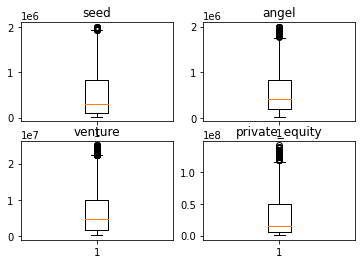

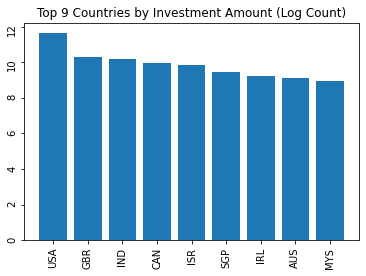

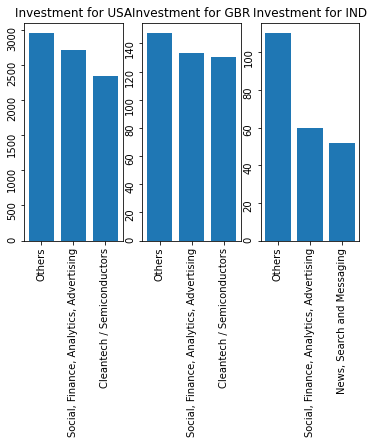

In [132]:
analyse()